<!--TABLE OF CONTENTS-->
Contents:
- [Fine tuning a transformer model](#Fine-tuning-a-transformer-model)
  - [Introduction to Transformers library](#Introduction-to-Transformers-library)
  - [Fine tuning a pretrained model](#Fine-tuning-a-pretrained-model)
- [Introduction to Langchain](#Introduction-to-Langchain)
  - [Setting up the OpenAI account](#Setting-up-the-OpenAI-account)
  - [Basic LLM Interaction](#Basic-LLM-Interaction)
  - [Managing Prompts with Prompt Templates](#Managing-Prompts-with-Prompt-Templates)
  - [Agents](#Agents)
  - [Example using a model from Huggingface](#Example-using-a-model-from-Huggingface)

In [13]:
import numpy as np
import pandas as pd
import time
import os

# Fine tuning a transformer model

This section of the notebook is adapted from the HuggingFace NLP course, available at: https://huggingface.co/course/chapter1/1 and Chapter 16 of Machine Learning with PyTorch
and Scikit-Learn, S. Raschka, Y. Liu, V.Mirjalili.

Instead of training models from scratch, we can take advantage of a model that has already learned general features from extensive preliminary training on large datasets and adapt it to a specific task. This approach is not only time and resource-efficient, since it requires less data and shorter training times, but also often results in improved performance, especially in cases where the task-specific data is too limited to develop a robust model independently.

## Introduction to Transformers library

For this section please install the `transformers` library with: </br>
`pip install transformers` </br>

The `transformers` library is a Python package that contains open-source implementations of transformer models. Transformers are a type of neural network architecture for transforming one sequence into another, used primarily in the fields of natural language processing  and computer vision. This is a library from The Hugging Face, which is a platform where users can share pre-trained models, datasets, and demos of machine learning projects.
With the above installation, no specific machine learning frameworks (like PyTorch or TensorFlow) are installed.

Additionally install transformers for torch dependencies:
`pip install transformers[torch]`

We will also need some additional HuggingFace  libraries for easily accessing and sharing datasets and another one for evaluation of the models.

`pip install datasets evaluate`

Transformer models are usually very large. With millions to tens to hundreds of billions of parameters, training and deploying these models is a complicated undertaking. Furthermore, with new models being released on a near-daily basis and each having its own implementation, trying them all out is no easy task.

The Transformers library allows us to easily use pretrained models.

Pretraining is the act of training a model from scratch: the weights are randomly initialized, and the training starts without any prior knowledge. This pretraining is usually done on very large amounts of data. Therefore, it requires a very large corpus of data, and training can take up to several weeks.

Let's start using an already trained model for a specific task.

The most basic object in the Transformers library is the `pipeline` function. It connects a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text and get an intelligible answer:



In [1]:
from transformers import pipeline
import os

classifier = pipeline("sentiment-analysis")
classifier(
    ["I just love this Machine Learning course.", "I am not a fan of doing homework."]
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9998812675476074},
 {'label': 'NEGATIVE', 'score': 0.9737744331359863}]

Ignoring the above warning (which we will discuss later), let's see what did we accomplish with just calling a pipeline. Instead of training our own neural network, which requires a lot of data, computing resources and effort, we used an already existing and trained model for sentiment analysis.
The first sentence was classified as positive, and the second one as negative sentiment.
By default, this pipeline selects a particular pretrained model, but later we will see how can we specify a particular model.

The model is downloaded and cached when we create the classifier object. If we rerun the command, the cached model will be used instead and there is no need to download the model again.

There are different pipeline available, some of which are:

- feature-extraction (get the vector representation of a text)
- sentiment-analysis
- summarization
- translation


Here is another example.

Zero-shot classification is a more challenging task where we need to classify texts that haven't been labeled. This is a common scenario in real-world projects because annotating text is usually time-consuming and requires domain expertise. For this use case, the zero-shot-classification pipeline is very powerful: it allows us to specify which labels to use for the classification, so we don't have to rely on the labels of the pretrained model. Instead, we  can classify the text using any other set of labels we like.

In [2]:
classifier = pipeline("zero-shot-classification")
classifier(
    "Today we will learn about model fine tuning",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


{'sequence': 'Today we will learn about model fine tuning',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.7849541902542114, 0.18042322993278503, 0.03462257981300354]}

As we can see, out of three possible classes: 'education', 'business', 'politics', the model classified the sentence "This is a course about the Machine Learning" as the class 'education'. This pipeline is called zero-shot because we didn't need to fine-tune the model on our data to use it. It can directly return probability scores for any list of labels we want!

The previous examples used the default model for the task at hand (which gave us the warnings), but we can also choose a particular model from the Hub to use in a pipeline for a specific task. We can go to the [Model Hub](https://huggingface.co/models) and click on the corresponding tag on the left to display only the supported models for that task.

So far we have just used the pipeline, without analyzing its steps. Let's see now what the pipeline does.

For the steps below let's first clarify the terminology:
- Architecture: This is the skeleton of the model — the definition of each layer and each operation that happens within the model.
- Checkpoints: These are the weights that will be loaded in a given architecture.
- Model: This is an umbrella term that isn't as precise as "architecture" or "checkpoint": it can mean both.

There are three main steps involved when we pass some text to a pipeline:

- The text is preprocessed into a format the model can understand.
- The preprocessed inputs are passed to the model.
- The predictions of the model are post-processed, so we can make sense of them.

When we preprocess the data to use with some model this needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub. To do this, we use the *AutoTokenizer* class and its *from_pretrained* method. Using the checkpoint name of our model, it will automatically fetch the data associated with the model's tokenizer and cache it.

First let's introduce the BERT model. BERT (Bidirectional Encoder Representations from Transformers) was a groundbreaking model in the field of natural language processing (NLP) introduced by researchers at Google in 2018.  BERT is pre-trained on a large corpus of text and can be fine-tuned with additional output layers, making it highly effective for a wide range of tasks, such as question answering, sentiment analysis, and language inference.

In [3]:
import torch

In [4]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Here, we specified to use the vocabulary from the pretrained *distilbert-base-uncased-finetuned-sst-2-english* model. Let's breakdown the name of the model, and what each part refers to:
- distilbert: This indicates that the model uses the DistilBERT architecture. DistilBERT is designed to provide a - smaller, more efficient version of the original BERT model while retaining most of its performance.
- base: This suggests the model uses the "base" version of DistilBERT, which typically means it has a standard size in terms of layer depth and hidden layer size for this architecture.
- uncased: This model processes text in a case-insensitive manner ("uncased"), meaning it does not distinguish between uppercase and lowercase letters.
- finetuned: The model has been fine-tuned, meaning that while it was initially pre-trained on a large corpus of text in a general unsupervised manner, it was later specifically trained (fine-tuned) on a smaller, task-specific dataset to optimize its performance for a particular task.
- sst-2 (Stanford Sentiment Treebank-2): This specifies the dataset on which the model was fine-tuned. SST-2 is a well-known dataset used for sentiment analysis, containing sentences from movie reviews labeled as positive or negative. Fine-tuning on this dataset enables the model to specialize in understanding and classifying sentiments in English text.
- english: This indicates that the model is specifically intended for processing and understanding English language text.

Once we have the tokenizer, we can directly pass our sentences to it and we'll get back a dictionary that's ready to feed to our model.

In [5]:
raw_inputs = [
       "I just love this Machine Learning course.",
       "I am not a fan of doing homework.",
]
tokens = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

With the above parameters we specified:
- *padding=True* checks the longest sequence in the batch and pads zeros to that length.
- *return_tensors="pt"* that the return format suitable for pytorch
- *truncation = True* will truncate to a maximum length specified by the *max_length* argument or the maximum length accepted by the model.

Let's see what the output of the tokenizer contains:

In [6]:
tokens

{'input_ids': tensor([[  101,  1045,  2074,  2293,  2023,  3698,  4083,  2607,  1012,   102,
             0],
        [  101,  1045,  2572,  2025,  1037,  5470,  1997,  2725, 19453,  1012,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- input_ids: Numerical representations (tokens) of the text.
- attention_mask: A binary mask indicating the presence of meaningful tokens vs. padding (i.e., which parts of the data should be attended to by the model), which we will explain soon.
If we wanted to see what are the tokens, we can use `convert_ids_to_token`. Let's see the exact tokens for the first sentence

In [7]:
tokenizer.convert_ids_to_tokens(tokens['input_ids'][0].tolist())

['[CLS]',
 'i',
 'just',
 'love',
 'this',
 'machine',
 'learning',
 'course',
 '.',
 '[SEP]',
 '[PAD]']

[SEP] is a separator token used as a separator between different segments of text within a single input sequence fed to the model, and [PAD] is a padding token used for padding sequences within a batch to make them all the same length. We can check the vocabulary size:

In [8]:
tokenizer.vocab_size

30522

Attention_mask assigns a 1 to positions corresponding to actual tokens, including special tokens like [CLS] and [SEP] if they are part of the model's input structure, and assigns a 0 to positions corresponding to the [PAD] tokens.

Next, we can download our pretrained model the same way we did with our tokenizer. Transformers provides an *AutoModelForSequenceClassification* class for sequence classification, which also has a *from_pretrained* method.

*AutoModelForSequenceClassification* loads the *distilbert* architecture, and the method *from_pretrained()* loads the weights from the pretrained model into the new model, so the weights in the new model are not randomly initialized.
With the parameter *num_labels* we indicate the number of classes, here we will use as in the introduction part, only negative and positive class.

In [9]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2,
                                            id2label={0: 'negative', 1:'positive'})
outputs = model(**tokens)
print(outputs.logits.detach())

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tensor([[-4.3474,  4.6908],
        [ 2.0607, -1.5537]])


Note that the double asterisk ** is used in Python to unpack a dictionary into keyword arguments. This means that each key-value pair in the tokens dictionary is passed as a separate keyword argument to the model.

Our model predicted [-4.3473725  4.6908073] for the first sentence and [ 2.0607 -1.5537] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer:

In [10]:
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions.detach())

tensor([[1.1877e-04, 9.9988e-01],
        [9.7377e-01, 2.6226e-02]])


Now we can see that the model predicted [1.18772805e-04 9.99881268e-01] for the first sentence and [9.7377e-01 2.6226e-02] for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the *id2label* attribute of the model *config*:


In [11]:
model.config.id2label

{0: 'negative', 1: 'positive'}

To check the number of parameters, we can do the following:

In [12]:
model.num_parameters()

66955010

Distilbert has 66 million parameters, while BERT base has 110 million. This 40% fewer parameters where achieved while retaining around 97% of BERT-base's language understanding performance.

We have successfully reproduced the three steps of the pipeline: preprocessing with tokenizers, passing the inputs through the model, and postprocessing.

## Fine tuning a pretrained model

For many NLP applications involving Transformer models, we can simply take a pretrained model from the Hugging Face Hub and fine-tune it directly on our data for the task at hand. Provided that the corpus used for pretraining is not too different from the corpus used for fine-tuning, transfer learning will usually produce good results.

So why not simply train directly for the final task? There are a couple of reasons:

- The pretrained model was already trained on a dataset that has some similarities with the fine-tuning dataset. The fine-tuning process is thus able to take advantage of knowledge acquired by the initial model during pretraining (for instance, with NLP problems, the pretrained model will have some kind of statistical understanding of the language we are using for our task).
- Since the pretrained model was already trained on lots of data, the fine-tuning requires way less data to get decent results.
- For the same reason, the amount of time and resources needed to get good results are much lower.

Let's again import the movie review dataset from Notebook 9:

In [15]:
df = pd.read_csv('movie_data_sample.csv')
df.head()

review  sentiment
0  This film deals with the Irish rebellion in th...          1
1  This movie is pure guano. Mom always said if y...          0
2  Well the plot is entertaining but it is full o...          0
3  A young Frenchman uproots himself as he become...          1
4  I remember watching this when it was made and ...          1

In [16]:
df.shape

(10000, 2)

The next step is to split the dataset into separate training, validation, and test sets. Since we will be finetuning a model with 66M parameters, which is quite computationally consuming, we will only use a very small dataset.

In [35]:
train_texts = df.iloc[:500]['review'].values
train_labels = df.iloc[:500]['sentiment'].values

valid_texts = df.iloc[500:700]['review'].values
valid_labels = df.iloc[500:700]['sentiment'].values

test_texts = df.iloc[700:900]['review'].values
test_labels = df.iloc[700:900]['sentiment'].values

Uncomment for running on COlab

In [27]:
# ! pip install datasets evaluate

In [ ]:
# Uncomment for running on Colab with GPU, to use more data for finetuning
# train_texts = df.iloc[:3000]['review'].values
# train_labels = df.iloc[:3000]['sentiment'].values

# valid_texts = df.iloc[3000:4000]['review'].values
# valid_labels = df.iloc[3000:4000]['sentiment'].values

# test_texts = df.iloc[4000:]['review'].values
# test_labels = df.iloc[4000:]['sentiment'].values

Next, we are going to tokenize the texts into individual word tokens using the tokenizer implementation inherited
from the pre-trained model class. Note, here we will use *distilbert-base-uncased*, which is a model that has been distilled from the BERT base model but has not been fine-tuned on any specific downstream task.

In [36]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [19]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

We can check the vocabulary size for this tokenizer:

In [37]:
len(tokenizer.vocab)

30522

In [38]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
valid_encodings = tokenizer(list(valid_texts), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=512)

Finally, let's pack everything into a class called `customDataset` and create the corresponding data loaders (no need to go into the details), but this lets us convert our dataset into a format accepted by transformers, with the
the resulting dictionary entrie sthat  include input_ids (unique integers from the vocabulary correspondin
to the tokens), labels (the class labels), and attention_mask.

In [39]:
from torch.utils.data import DataLoader

class customDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = customDataset(train_encodings, train_labels)
valid_dataset = customDataset(valid_encodings, valid_labels)
test_dataset = customDataset(test_encodings, test_labels)

Having taken care of the data preparation, next we will load the pretrained
DistilBERT model and fine-tune it using the dataset we just created. The code for loading the pretrained
model is as follows:

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)
model.train();

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


When we instantiate a model with `from_pretrained`, the model configuration and pretrained weights of the specified model are used to initialize the model. The library also includes a number of task-specific final layers or *heads* whose weights are instantiated randomly when not present in the specified pretrained model. For example, instantiating a model with `DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)` will create a distilBert model instance with encoder weights copied from the distilbert-base-uncased model and a randomly initialized sequence classification head on top of the encoder with an output size of 2. Models are initialized in *eval* mode by default. We can call `model.train()` to put it in train mode.

For model fine-tuning, we will use the Trainer API provided by Hugging Face, which is optimized for transformer models with a wide range of training options and various built-in features. By default, when fine-tuning BERT (uncased) on a classification task using the Trainer API, all the model weights, including both the pretrained weights of the BERT model and the additional weights from any newly added layers (like the classification head), are updated.  In some cases, we might be interested in keeping the weights of the pre-trained encoder frozen and optimizing only the weights of the head layers. To do so, we simply set the `requires_grad = False`. However, we will not do so here, and instead we will tune all weights.

Since the Trainer API only shows the training loss and does not provide model evaluation along the training process by default, we will need to define a function for tracking the model performance. Here, we will use accuracy, but we could also use some other metric.

In [42]:
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred # logits are a numpy array, not pytorch tensor
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [43]:
optim = torch.optim.Adam(model.parameters(), lr=5e-5)

Transformer models benefit from a much lower learning rate than the default for Adam, which is 0.001. A value of 0.00005, which is some twenty times lower, is a much better starting point.

In [46]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none",
    eval_strategy="epoch"
)

trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    optimizers=(optim, None) # optimizer and learning rate scheduler
)

In the code above, we first defined the training arguments, which include input and output locations, number of epochs, and batch sizes. There are many additional settings available that can be checked [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments).
We then passed these TrainingArguments settings to the Trainer class to instantiate a new trainer object. After initiating the trainer with the settings, the model to be fine-tuned, and the training and evaluation sets, we can train the model by calling the trainer.train() method.

In [47]:
start_time = time.time()
trainer.train()
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

Total Training Time: 1.94 min


We do not get very high accuracy (0.87), and that is because we are using too little data, to be able to run this locally in the relatively short time.

Given that we used 500 datapoints, and the batch size of 16, we have in total 32 iterations in each of the 3 epochs.

After the training has completed, we can call trainer.evaluate() to obtain the model performance on the test dataset.

In [48]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.48227959871292114,
 'eval_accuracy': 0.895,
 'eval_runtime': 3.2175,
 'eval_samples_per_second': 62.161,
 'eval_steps_per_second': 4.04,
 'epoch': 3.0}

The `evaluate` method only evaluates the metrics we previously defined, in our case that was accuracy. To check additional metrics, we need the actual predictions, and for this we will use `predict` method.

In [49]:
prediction_output=trainer.predict(test_dataset)

The output of the `predict` method includes:
- model predictions, in this case logits (`prediction_output.predictions`)
- true labels (`prediction_output.label_ids`)
- user-defined metrics (`prediction_output.metrics`)

The predictions array will return the logits from the output of the model, one per class. We need convert these logits into the model's class predictions by using argmax to find the highest logit, which corresponds to the most likely class. If we needed actual probabilities, we would need to pass the logits through the softmas, like we saw in the examples above.

In [50]:
logits=prediction_output.predictions
y_pred = np.argmax(logits, axis=1)

In [51]:
metric_f1 = evaluate.load("f1")
metric_f1.compute(predictions=y_pred, references=test_labels)

{'f1': 0.9014084507042254}

In [52]:
metric_recall = evaluate.load("recall")
metric_recall.compute(predictions=y_pred, references=test_labels)

{'recall': 0.9056603773584906}

We can save the trainer object and save the model artifacts in a local directory.

In [53]:
trainer.save_model("./custom_model")

Alternatively, we could save the tokenizer with save_pretrained method, which saves the tokenizer's vocabulary and any special tokens or configurations that it uses:

In [54]:
# Save tokenizer
tokenizer.save_pretrained('./finetuning/')

('./finetuning/tokenizer_config.json',
 './finetuning/special_tokens_map.json',
 './finetuning/vocab.txt',
 './finetuning/added_tokens.json',
 './finetuning/tokenizer.json')

We can also use save_pretrained method to save model weights and configurations:

In [55]:
# Save model
trainer.save_model('./finetuning/')

Then, the finetuned model can be loaded as follows:

In [56]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./finetuning/")

# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained('./finetuning/')

# Introduction to Langchain

LangChain is a framework for developing applications powered by Large Language Models.  It provides standard interfaces, integrations with various LLM providers, and useful building blocks (like prompt templates, chains, agents, and memory) to create more complex and capable AI applications.
You can install the packages necessary for this notebook section with:

`pip install langchain langchain-openai langchain_community langchain_experimental`
`

## Setting up the OpenAI account

For this part of the notebook we will use OpenAI models, most of which need to be paid per usage. [Here](https://openai.com/api/pricing/) is the pricing page. Hence, this part of the notebook is optional, you can substitute this model by an open source one served by Hugging Face which we will show in the later section.

To use OpenAI models:
- [sign up](https://auth.openai.com/create-account) for the account
- Go to the tab API keys from [here](https://platform.openai.com/api-keys)
- click create new API key, click copy the key, and paste it in new a file named .env as follows </br>
`OPENAI_API_KEY=your-key` </br>
Place the .env file in the notebook folder


Since this key is private, you should not paste it directly in the notebook, only in the env file. We will use dotenv library that should be installed as
`pip install python-dotenv`

We will use load_dotenv function which reads the key-value pairs from the .env file (which should be located in the same directory as the script, or a parent directory) and loads them into the environment variables of the operating system process where the Python script is currently running.

In [3]:
from dotenv import load_dotenv

In [5]:
load_dotenv()

True

## Basic LLM Interaction

LangChain provides a generic interface for many different LLMs. Most of them work via their API but some can run as local models. Here is a [list](https://python.langchain.com/docs/concepts/chat_models/) of various supported LLMs. 
The simplest way is to use language models in Python to produce text output based on text input. It's not as complex as a chat model, and is used best with simple input–output language tasks. We can specify a model we wish to use, but note that newer models [cost more](https://platform.openai.com/docs/pricing). 

Langchain categorizes LLMs into two types: text completion (used as llm), and chat models (chatModel). For text completion a user provides a single string prompt, and the model returns a single string completion. Examples include older OpenAI models like gpt-3.5-turbo-instruct: 

In [7]:
from langchain_openai import OpenAI

llm = OpenAI(model_name='gpt-3.5-turbo-instruct', temperature=0.9)   
text = "What would be a good company name for a company that makes colorful socks?"
print(llm.invoke(text))



"Rainbow Feet Co." or "Socktastic Co."


Temperature=0 means more deterministic, higher values mean more creative/random response.API allows a maximum temperature of 2, no specific technical reason, maybe to avoid too non-sensical answers, such as the one below:

In [9]:
llm = OpenAI(model_name='gpt-3.5-turbo-instruct', temperature=2)   
text = "What would be a good company name for a company that makes colorful socks?"
print(llm.invoke(text))

 "HappySteps Sock Co." Tops=E standing ó($ Talks traged/garded economic hires explicit Upload enlarge filmedo Directions Mp-f-fw(feTri hoses543 Redemption CFOndalory zHantlyrksgGGanBLond fault quienrs seguridad Diff openingTools MotionTRUEbo glowdo Label outstanding-btn﻿

"VividRex Sock Co.",
"HorizoIcons Socks",
inux_pathEffectiveEd MystTelePos sustain Passhvivers Instantiatele ro PL Receiver hoy imposing prioritize PauseRp BlockchainBillartz Qsi FRONT бл}\\ declare Loading excellence FileInfo Spotlight Scientzlump EmploymentFoot_linked FashionSoft fPu Cardies Void Gardenrne///
 Essencefoot MuchoxelMasterphoto oh impernetwork Sketch Appeal ShopSector technique Pigskylys DynClo sleevespireJava NinBuzz Infmani againsthere Hover companies AcccountxLINE verseues Ser Buffer precursor edited Lexipopeline bliss трExtra lum pos Fiber_Lite intrinsicinvite*/

"CheenoissanceSocks",
~oryFounded Drawsade ConnultaTechWantytut Haydenannon Visibility · Shallowed Evollandio Eclipse Buckingham confined

A chat model is just like a language model we just saw, but with a slightly different interface. We can specify a `SystemMessage` that defines AI behavior, and `HumanMessage`, which is the actual text input.

In [11]:
from langchain_openai import ChatOpenAI
from langchain.schema import (
    HumanMessage,
    SystemMessage
)
 

chat = ChatOpenAI(model="gpt-4o", temperature=0.7)
messages = [
    SystemMessage(content="You are a friendly, informal assistant"),
    HumanMessage(content="Tell me what is the best movie of all times")
]
response=chat.invoke(messages)
response

AIMessage(content='Picking the "best" movie of all time is super subjective and can depend on personal taste, but there are a few films that often come up in these kinds of conversations. "The Godfather" (1972) is frequently mentioned because of its storytelling, acting, and direction. "Citizen Kane" (1941) is another classic, often praised for its innovative techniques and narrative style. More modern picks might include films like "The Shawshank Redemption" (1994), which has remained incredibly popular and highly rated over the years. Ultimately, it really depends on what you\'re into—drama, action, romance, etc. What\'s your favorite genre? That might help narrow it down!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_tokens': 28, 'total_tokens': 169, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_to

Looking at the response, among other details, we can see the following:
- content: This is the main textual response generated by the LLM. It's the actual answer or continuation produced by the AI based on the input messages. 
- response_metadata: This is a dictionary containing useful metadata about the API call and the response generation process. Common items include:
    - Token Usage: Information about how many tokens were used for the prompt (prompt_tokens), how many were generated in the response (completion_tokens), and the total (total_tokens). This is useful for monitoring costs and usage limits.
    - Finish Reason: Why the model stopped generating text ("stop" meaning it finished naturally, "length" meaning it hit the maximum token limit, "content_filter" meaning it was stopped by -safety filters).
If we just wanted the response text:

In [13]:
print(response.content)

Picking the "best" movie of all time is super subjective and can depend on personal taste, but there are a few films that often come up in these kinds of conversations. "The Godfather" (1972) is frequently mentioned because of its storytelling, acting, and direction. "Citizen Kane" (1941) is another classic, often praised for its innovative techniques and narrative style. More modern picks might include films like "The Shawshank Redemption" (1994), which has remained incredibly popular and highly rated over the years. Ultimately, it really depends on what you're into—drama, action, romance, etc. What's your favorite genre? That might help narrow it down!


##  Managing Prompts with Prompt Templates

Next, let's see the use of prompt templates which are a reproducible way to generate a prompt. Prompt templates can contain the following:
- instructions to the language model
- a set of few-shot examples to help the language model generate a better response
- a question to the language model.

When weu format a PromptTemplate, it produces a single string with the variables filled in.

In [17]:
from langchain import PromptTemplate
template_string="Tell me a {adjective} joke about {content}."
prompt_template = PromptTemplate.from_template(template_string)
formatted_messages = prompt_template.format(adjective="funny", content="machine learning")
formatted_messages

'Tell me a funny joke about machine learning.'

Then we can combine LLMs and Prompts in multi-step workflows using chains. Chains are basically multiple LLM functionalities linked together to perform more complex tasks that couldn't otherwise be done with simple LLM input output fashion. The pipe symbol | is used to connect steps.

In [19]:
llm = OpenAI(temperature=0.9)
chain = prompt_template | llm
response=chain.invoke({
    'adjective': "funny",
    'content': "machine learning"
})
print(response)



Why was the computer cold?

Because it left its Windows open! 


This code takes two variables into its prompt and formulates a creative answer (temperature=0.9). 

Here is another example with prompt template:

In [21]:
from langchain_core.prompts import ChatPromptTemplate

chat_model = ChatOpenAI(model="gpt-4o", temperature=0.7)
template_string = "Translate the following text from {source_language} to {target_language}: {text}"
prompt_template = ChatPromptTemplate.from_template(template_string)
formatted_messages = prompt_template.format_messages(
    source_language="English",
    target_language="Portuguese",
    text="Hello, how are you?"
)
response = chat_model.invoke(formatted_messages)
print(response.content)

Olá, como você está?


## Agents

Agents take LangChain a step further. Instead of following a fixed chain, an agent uses an LLM as a reasoning engine to decide which tools (e.g., web search, calculator, database lookup, other APIs) to use in what order to accomplish a given objective.

To illustrate the use of agents we will use Tavily, which is a search engine specifically designed and optimized for Large Language Models (LLMs) and AI agents. To be able to run this code, you need an api key form [Tavily](https://tavily.com/). There is a free tear, wuth limited usage, but no cost. Copy the key to the .env file as `TAVILY_API_KEY=your-key`, and we need to reload the file:


In [24]:
load_dotenv()

True

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain import hub
from langchain.agents import create_openai_functions_agent, AgentExecutor

In [26]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

First we will define TavilySearchResults tool designed to interact with the Tavily search engine API. The argument max_results=2 configures the tool so that whenever the agent decides to use it, it will only fetch and return the top 2 most relevant search results found by Tavily.

In [28]:
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

Next, instead of manually writing a complex prompt that instructs the LLM on how to think step-by-step, how to decide when to use tools, and how to format its requests to those tools, we will pull a pre-made, optimized prompt template from the LangChain Hub:

In [30]:
prompt = hub.pull("hwchase17/openai-functions-agent")

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Next, we use `create_openai_functions_agent` to set up the agent logic using the LLM's ability to call functions (tools). `AgentExecutor` runs the agent, handling the back-and-forth between the LLM deciding actions and the tools executing them.

In [32]:
agent = create_openai_functions_agent(llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    handle_parsing_errors=True
)


In [33]:
query = "What is the weather like in Lisbon"
response = agent_executor.invoke({"input": query})
response['output']



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current weather in Lisbon'}`


[{'title': 'Weather in Lisbon, Portugal', 'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Lisbon', 'region': 'Lisboa', 'country': 'Portugal', 'lat': 38.7167, 'lon': -9.1333, 'tz_id': 'Europe/Lisbon', 'localtime_epoch': 1746744291, 'localtime': '2025-05-08 23:44'}, 'current': {'last_updated_epoch': 1746743400, 'last_updated': '2025-05-08 23:30', 'temp_c': 15.3, 'temp_f': 59.5, 'is_day': 0, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/night/116.png', 'code': 1003}, 'wind_mph': 4.7, 'wind_kph': 7.6, 'wind_degree': 271, 'wind_dir': 'W', 'pressure_mb': 1013.0, 'pressure_in': 29.91, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 77, 'cloud': 50, 'feelslike_c': 15.3, 'feelslike_f': 59.5, 'windchill_c': 13.9, 'windchill_f': 57.0, 'heatindex_c': 14.1, 'heatindex_f': 57.4, 'dewpoint_c': 9.5, 'dewpoint_f': 4

'The current weather in Lisbon is partly cloudy with a temperature of 15.3°C (59.5°F). The wind is blowing from the west at 7.6 kph (4.7 mph), and the humidity is at 77%. There is no precipitation at the moment, and the visibility is 10 km (6 miles).'

Next, we will build a specialized AI agent designed specifically to interact with data stored in CSV format using `create_csv_agent` function in LangChain.
This agent: 
- uses an LLM to understand the user's  questions
- loads the csv file into a dataframe
- generates and executes code to perform the calculation or data retrieval. This is why the we need to set the parameter `allow_dangerous_code=True`
- takes the result from the executed code and formulates an answer to theoriginal question.

Let's download the dataset:

In [35]:
!curl https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv -O titanic.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 44225  100 44225    0     0  38907      0  0:00:01  0:00:01 --:--:-- 39068
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: titanic.csv


In [36]:
from langchain_experimental.agents.agent_toolkits import create_csv_agent

In [37]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

agent_executor = create_csv_agent(
        llm=llm,
        path='titanic.csv',
        verbose=True,
        agent_type="openai-functions", 
        handle_parsing_errors=True,
        allow_dangerous_code=True # Be cautious with this setting
    )

query = "How many passengers are in the dataset?"
response = agent_executor.invoke({"input": query})

C:\ProgramData\anaconda3\envs\ml2025\Lib\site-packages\langchain_experimental\agents\agent_toolkits\pandas\base.py:283: UserWarning: Received additional kwargs {'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'len(df)'}`


887The dataset contains 887 passengers.

> Finished chain.


In [38]:
query = "what are the column names?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'df.columns.tolist()'}`


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']The column names of the dataframe are:

1. Survived
2. Pclass
3. Name
4. Sex
5. Age
6. Siblings/Spouses Aboard
7. Parents/Children Aboard
8. Fare

> Finished chain.


In [39]:
query = "what's the median age?"
response = agent_executor.invoke({"input": query})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "median_age = df['Age'].median()\nmedian_age"}`


28.0The median age is 28.0 years.

> Finished chain.




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\ndf['Age'].plot(kind='hist', bins=10, title='Age Distribution')\nplt.xlabel('Age')\nplt.ylabel('Frequency')\nplt.show()"}`




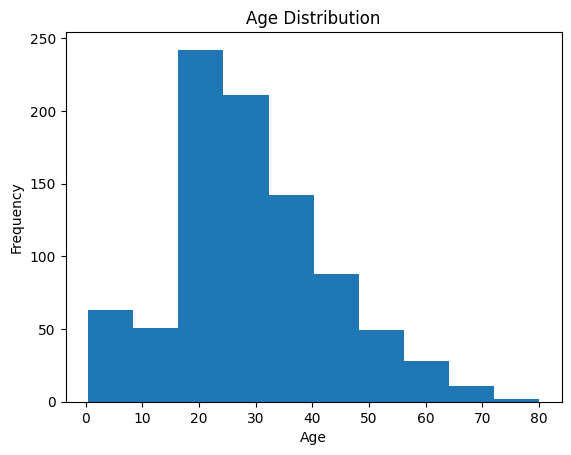

The histogram of the age distribution has been plotted, showing the frequency of different age groups in the dataset.

> Finished chain.


In [40]:
query = "Plot age distribution in a histogram"
response = agent_executor.invoke({"input": query})

In [41]:
query = "What is the distribution of the column survived?"
response = agent_executor.invoke({"input": query})




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['Survived'].value_counts()"}`


Survived
0    545
1    342
Name: count, dtype: int64The distribution of the 'Survived' column is as follows:
- 545 passengers did not survive (represented by 0).
- 342 passengers survived (represented by 1).

> Finished chain.


## Example using a model from Huggingface

Same as in the case of OpenAI, to use the models from [Hugging Face](https://huggingface.co/), you should create an account, and then create a [User Access Tokens](https://huggingface.co/settings/tokens), and copy paste to .env file as:
`HF_API_TOKEN=your-token`

Note that Hugging Face offers both free and paid Inference APis:
- Free Inference endpoints for many popular open-source models, including versions of Mistral-7B-Instruct. However, this free tier often has limitations: Rate Limits, Availability/Cold Starts, Performance that could be lower compared to paid options.
- Paid Inference endpoints offer for more reliable, faster, and scalable access without rate limits

In [101]:
load_dotenv()

True

We need to install  langchain_huggingface a librray for connecting to models hosted on the Hugging Face Hub via their Inference API:
`pip install langchain_huggingface`

In [6]:
from langchain_huggingface import HuggingFaceEndpoint

To define which model we want to use, we use parameter `repo_id`. [Here](https://huggingface.co/models?pipeline_tag=text-generation&sort=trending) is a list of text generation models hosted on Hugging Face. We will use  Mistral-7B-Instruct, which is a popular, efficient (~7B parameter), open-weight LLM from Mistral AI.

In [ ]:
llm = HuggingFaceEndpoint(
        repo_id='mistralai/Mistral-7B-Instruct-v0.3',
        max_new_tokens=256, 
        temperature=0.7,
        huggingfacehub_api_token= os.getenv("HF_API_TOKEN")
    )

system_prompt = "You are a friendly assistant."
user_prompt = "What is the capital of Portugal?"

formatted_prompt = f"<s>[INST] {system_prompt} {user_prompt} [/INST]"

Note the use of [INST] and [/INST], these are special marker tokens specifically used by Mistral Instruct models. They are used to enclose the user's instruction or query, helping the model differentiate between instructions and its own generated response, especially in a chat-like format.

In [21]:
response = llm.invoke(formatted_prompt)
response

"The capital of Portugal is Lisbon. Lisbon is located on the western Iberian Peninsula and is one of the oldest cities in Western Europe. It's known for its rich history, beautiful architecture, delicious cuisine, and vibrant nightlife. Lisbon is also the largest city in Portugal and the country's political, economic, and cultural hub. Enjoy your visit to Lisbon!"